# Importing the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import io
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input

2024-07-31 12:15:59.750651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 12:15:59.750753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 12:15:59.887758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setting

In [2]:
api_key = 'your_api_key'
symbol = 'your_stock_symbol'  # Example stock symbol: 'MXL'
timesteps = 60

# Reading the data from API

In [3]:
def pre_process(data):

    # Change the date column to datetime
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    # sort the data by date
    data = data.sort_values('timestamp')
    data = data.reset_index(drop=True)

    # Drop rows with missing values
    data = data.dropna()

    # Split data into training and testing sets
    # last 14 days of data will be used for testing
    test_data = data[-13:]
    train_data = data[:-13]

    # Add new data to test_data
    # You can set how many 
    newData_num = 1
    for i in range(newData_num):

        latest_time = test_data['timestamp'].iloc[-1]
        # one day after the last day of the test data
        # Check the day of the week (0 = Monday, 1 = Tuesday, ..., 5 = Saturday, 6 = Sunday)
        day_of_week = latest_time.weekday()

        # If the latest time is a Friday (4), add three days to get Monday
        # If it's a Saturday (5), add two days to get Monday
        # Otherwise, just add one day
        if day_of_week == 4:
            next_weekday = latest_time + pd.Timedelta(days=3)
        elif day_of_week == 5:
            next_weekday = latest_time + pd.Timedelta(days=2)
        else:
            next_weekday = latest_time + pd.Timedelta(days=1)

        latest_data_df = pd.DataFrame(
            {
                'timestamp': next_weekday,
                'open': 0.0,
                'high': 0.0,
                'low': 0.0,
                'close': 0.0,
                'volume': 0.0
            }, index=[0]
        )
        test_data = pd.concat([test_data, latest_data_df], ignore_index=True)

    # # Save the data in CSV format
    # train_data.to_csv(symbol + '_train_data.csv', index=False)
    # test_data.to_csv(symbol + '_test_data.csv', index=False)
    return train_data, test_data




#  receive data from api in csv format
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={api_key}&datatype=csv'
response = requests.get(url)
# Check if the request was successful
if response.status_code == 200:
    # Convert the response content to a CSV format and load it into a DataFrame
    data = pd.read_csv(io.StringIO(response.text))
    # Process the data
    train_data, test_data = pre_process(data)
else:
    print(f"Failed to retrieve data: {response.status_code}")


# Selecting the target variable
## You can choose whether to use open, high, low, close, or volume as the target variable

In [4]:
#  For Open Price
# training_set = train_data.iloc[:, 1:2].values
# For Close Price
training_set = train_data.iloc[:, 4:5].values

# Visualizing the training data

In [5]:
train_data.head()

,timestamp,open,high,low,close,volume
0,2010-03-24,17.95,19.39,17.56,18.70,6890400
1,2010-03-25,18.90,19.50,18.04,18.04,1853900
2,2010-03-26,18.19,18.62,17.90,18.62,472400
3,2010-03-29,18.75,18.97,18.19,18.70,371700
4,2010-03-30,18.70,18.70,18.20,18.25,165000


# Visualizing the testing data

In [6]:
test_data.head()

,timestamp,open,high,low,close,volume
0,2024-07-12,22.63,23.21,22.47,22.60,621274.0
1,2024-07-15,22.80,24.35,22.75,24.14,804393.0
2,2024-07-16,24.39,24.82,24.00,24.72,922384.0
3,2024-07-17,25.05,26.59,24.91,25.38,1704424.0
4,2024-07-18,25.75,26.13,24.14,24.44,1036158.0


# Feature Scaling between 0 and 1

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output

In [8]:
X_train = []
y_train = []
for i in range(timesteps, len(training_set)):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Building the LSTM model

In [9]:
model = Sequential()

model.add(Input(shape=(X_train.shape[1], 1)))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0127
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0025
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0021
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0019
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0017
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0013
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0013
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0012
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0013
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0013
Epoch 12/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0010
Epoch 13/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.2286e-04
Epoch 14/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0011
Epoch 15/100
111/111 ━━━━

# Saving the model

In [10]:
model.save_weights('/kaggle/working/model_weights.weights.h5')

# Making the predictions 

In [11]:
# dataset_total = pd.concat((train_data['open'], test_data['open']), axis = 0)
dataset_total = pd.concat((train_data['close'], test_data['close']), axis = 0)

inputs = dataset_total[len(dataset_total) - len(test_data) - timesteps:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(timesteps, 74):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


# Comparing the predicted and actual stock prices

In [14]:
timestamps = test_data['timestamp'].values[:len(predicted_stock_price)]
# actual_stock_price = test_data['open'].values[:len(predicted_stock_price)]
actual_stock_price = test_data['close'].values[:len(predicted_stock_price)]



# Print the predictions with timestamps
print("Predicted Stock Prices:")
for timestamp, price in zip(timestamps, predicted_stock_price):
    print(f"Timestamp: {timestamp}, Predicted Price: {price[0]}")

# Print the actual values with timestamps for comparison
print("\nActual Stock Prices:")
for timestamp, price in zip(timestamps, actual_stock_price):
    print(f"Timestamp: {timestamp}, Actual Price: {price}")



Predicted Stock Prices:
Timestamp: 2024-07-12T00:00:00.000000000, Predicted Price: 22.12953758239746
Timestamp: 2024-07-15T00:00:00.000000000, Predicted Price: 22.251468658447266
Timestamp: 2024-07-16T00:00:00.000000000, Predicted Price: 23.387746810913086
Timestamp: 2024-07-17T00:00:00.000000000, Predicted Price: 24.308589935302734
Timestamp: 2024-07-18T00:00:00.000000000, Predicted Price: 24.985519409179688
Timestamp: 2024-07-19T00:00:00.000000000, Predicted Price: 24.474681854248047
Timestamp: 2024-07-22T00:00:00.000000000, Predicted Price: 23.79253578186035
Timestamp: 2024-07-23T00:00:00.000000000, Predicted Price: 24.331031799316406
Timestamp: 2024-07-24T00:00:00.000000000, Predicted Price: 23.688997268676758
Timestamp: 2024-07-25T00:00:00.000000000, Predicted Price: 22.555328369140625
Timestamp: 2024-07-26T00:00:00.000000000, Predicted Price: 17.10582160949707
Timestamp: 2024-07-29T00:00:00.000000000, Predicted Price: 13.715368270874023
Timestamp: 2024-07-30T00:00:00.000000000, P

# Visualizing the results
## As we can see, the model does not predict prices accurately, but it does a good job of capturing the general trend of the stock price.
## The model predicted the stock prices for the next 14 days (last 13 days + 1 coming day).

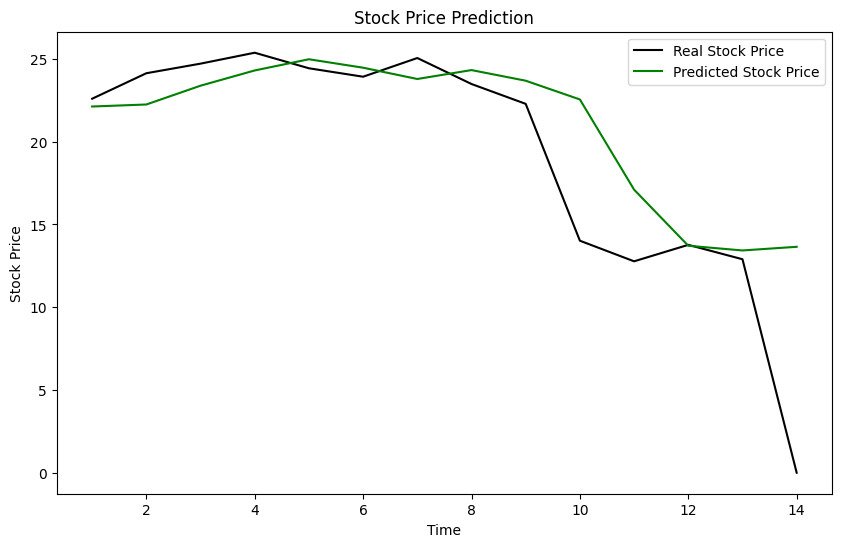

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(actual_stock_price) + 1), actual_stock_price, color='black', label='Real Stock Price')
plt.plot(range(1, len(predicted_stock_price) + 1), predicted_stock_price, color='green', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()